In [1]:
import matplotlib.pyplot as plt
from get_data import *
import tqdm
import glob
import datetime
from argparse import ArgumentParser
import pickle
import flash_order
from matplotlib.ticker import MaxNLocator

0050

In [2]:
stock_code = '0050'
fod = flash_order.FlashOrderCalculator(stock_code)

2022-12-24 14:14:41.119 | INFO     | get_data.py         :   36 | Got cache at D:\hkust\Course_2022_Fall\MFAS56001R2\mafs6100-order-placement-strategy_local\cache\0050.pkl - 17.69s


In [12]:
fod.classify(max_dur_ms=100)
fod_dict = fod.fod
fod_dict_100 = fod_dict[100][100]
#res_200 = res[200]

2022-12-24 14:15:33.475 | INFO     | flash_order.py      :   40 | Classification of max_dur_ms=100 & trick_trade_thres_ms=100 done already


In [13]:
def get_flick_influ(fod_dict, decay = 5):
    
    '''
    fod_dict: the dictionary of classified flickering quotes
    decay: decay of time after observing flickering quotes
    '''
    
    data  =fod.data_gb
    bid_mv = []
    ask_mv = []
    
    for item in tqdm.tqdm(fod_dict):
        start_time = item['start']
        end_time = item['end']
        date = item['date']
        quotes = data[date][ (data[date].dt >= end_time) & (data[date].dt <= end_time + datetime.timedelta(seconds = decay))]
        quotes = quotes[quotes['BP1']>0]
        if len(quotes) == 0:
            continue
        orig_mid = quotes.iloc[0]['mid']
        mid = quotes.iloc[-1]['mid']
        mv_pct = (mid / orig_mid - 1) * 100
        if item['side'] == 'bid':
            bid_mv.append(mv_pct)
        else:
            ask_mv.append(mv_pct)
    
    return bid_mv, ask_mv

In [14]:
### generate simulation results

bid_influ, ask_influ = [], []
for i in range(1, 31):
    bid_mv, ask_mv = get_flick_influ(fod_dict_100, i)
    bid_influ.append(bid_mv)
    ask_influ.append(ask_mv)

100%|██████████| 8398/8398 [00:08<00:00, 953.70it/s] 


Text(0, 0.5, 'mean of return')

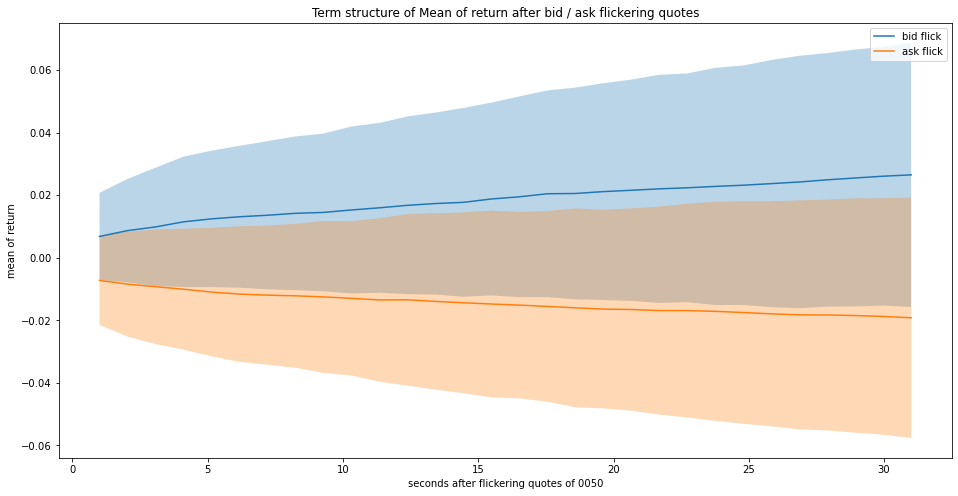

In [15]:
## plotting

fig, ax = plt.subplots(figsize = (16, 8))
x_bid = np.array([np.mean(bid_mv) for bid_mv in bid_influ])
s_bid = np.array([np.std(bid_mv) for bid_mv in bid_influ])
ax.plot(np.linspace(1,31,30), x_bid, label = 'bid flick')
ax.fill_between(np.linspace(1,31,30),x_bid-s_bid,x_bid+s_bid, alpha = 0.3)
x_ask = np.array([np.mean(ask_mv) for ask_mv in ask_influ])
s_ask = np.array([np.std(ask_mv) for ask_mv in ask_influ])
ax.plot(np.linspace(1,31,30), x_ask, label = 'ask flick')
ax.fill_between(np.linspace(1,31,30),x_ask-s_ask,x_ask+s_ask, alpha = 0.3)
ax.legend(loc = 'upper right')
ax.set_title('Term structure of Mean of return after bid / ask flickering quotes')
ax.set_xlabel(f'seconds after flickering quotes of {stock_code}')
ax.set_ylabel('mean of return')